In [2]:
from Helper_Functions import Sudoku_oracle, Grover_operator, Get_Data_from_Fake_backend
import numpy as np
import math

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.primitives import StatevectorSampler
from qiskit_ibm_runtime.fake_provider import FakeAlgiers
from qiskit.visualization import plot_distribution

## 4.1 Solving Sudoku using Grover's Algorithm <a id="sudoku"></a>

The oracles used throughout this chapter so far have been created with prior knowledge of their solutions. We will now solve a simple problem using Grover's algorithm, for which we do not necessarily know the solution beforehand. Our problem is a 2×2 binary sudoku, which in our case has two simple rules:

- No column may contain the same value twice
- No row may contain the same value twice

If we assign each square in our sudoku to a variable like so:

![2×2 binary sudoku, with each square allocated to a different variable](static/binary_sudoku.png)

we want our circuit to output a solution to this sudoku.


Since we need to check down both columns and across both rows, there are 4 conditions we need to check:

```
v0 ≠ v1   # check along top row
v2 ≠ v3   # check along bottom row
v0 ≠ v2   # check down left column
v1 ≠ v3   # check down right column
```

Remember we are comparing classical (computational basis) states. For convenience, we can compile this set of comparisons into a list of clauses:

In [3]:
clause_list = [[0, 1],
               [0, 2],
               [1, 3],
               [2, 3]]

In [4]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')

### The Sudoku Oracle <a id="sudoku_oracle"></a>



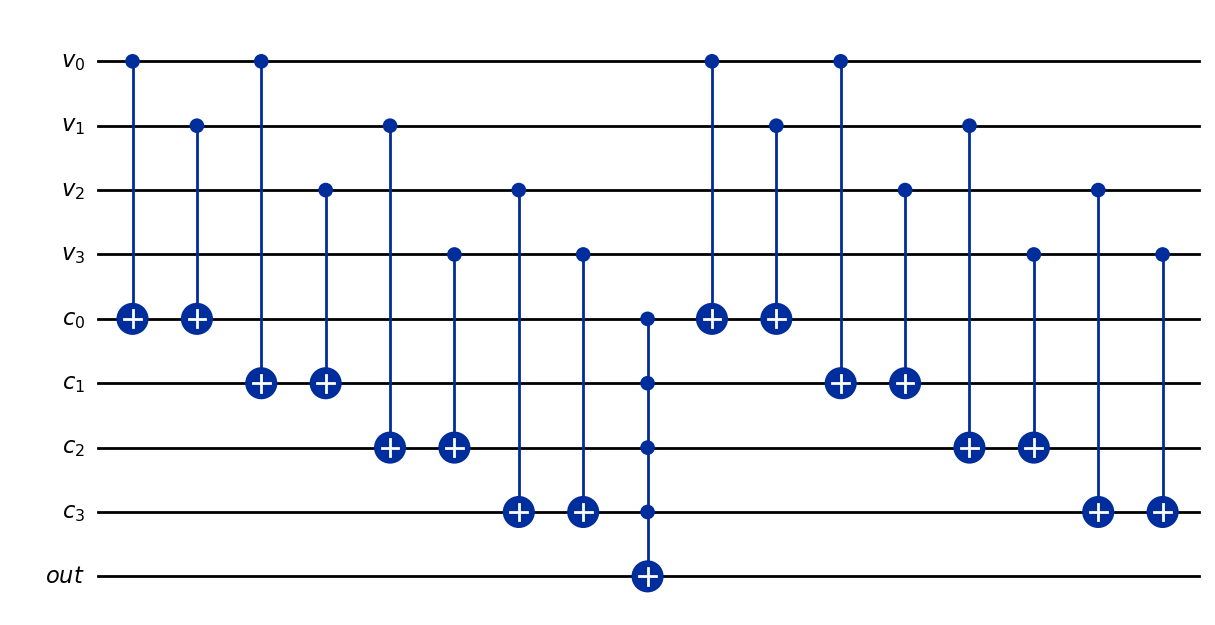

In [5]:

oracle = Sudoku_oracle(var_qubits, clause_list, clause_qubits, output_qubit)
oracle.draw(output="mpl", style="iqp")


### Grover Operator <a id="grover_operator"></a> using the oracle we just created, we can now build the Grover operator. We will apply the reflection to all 4 variable qubits.

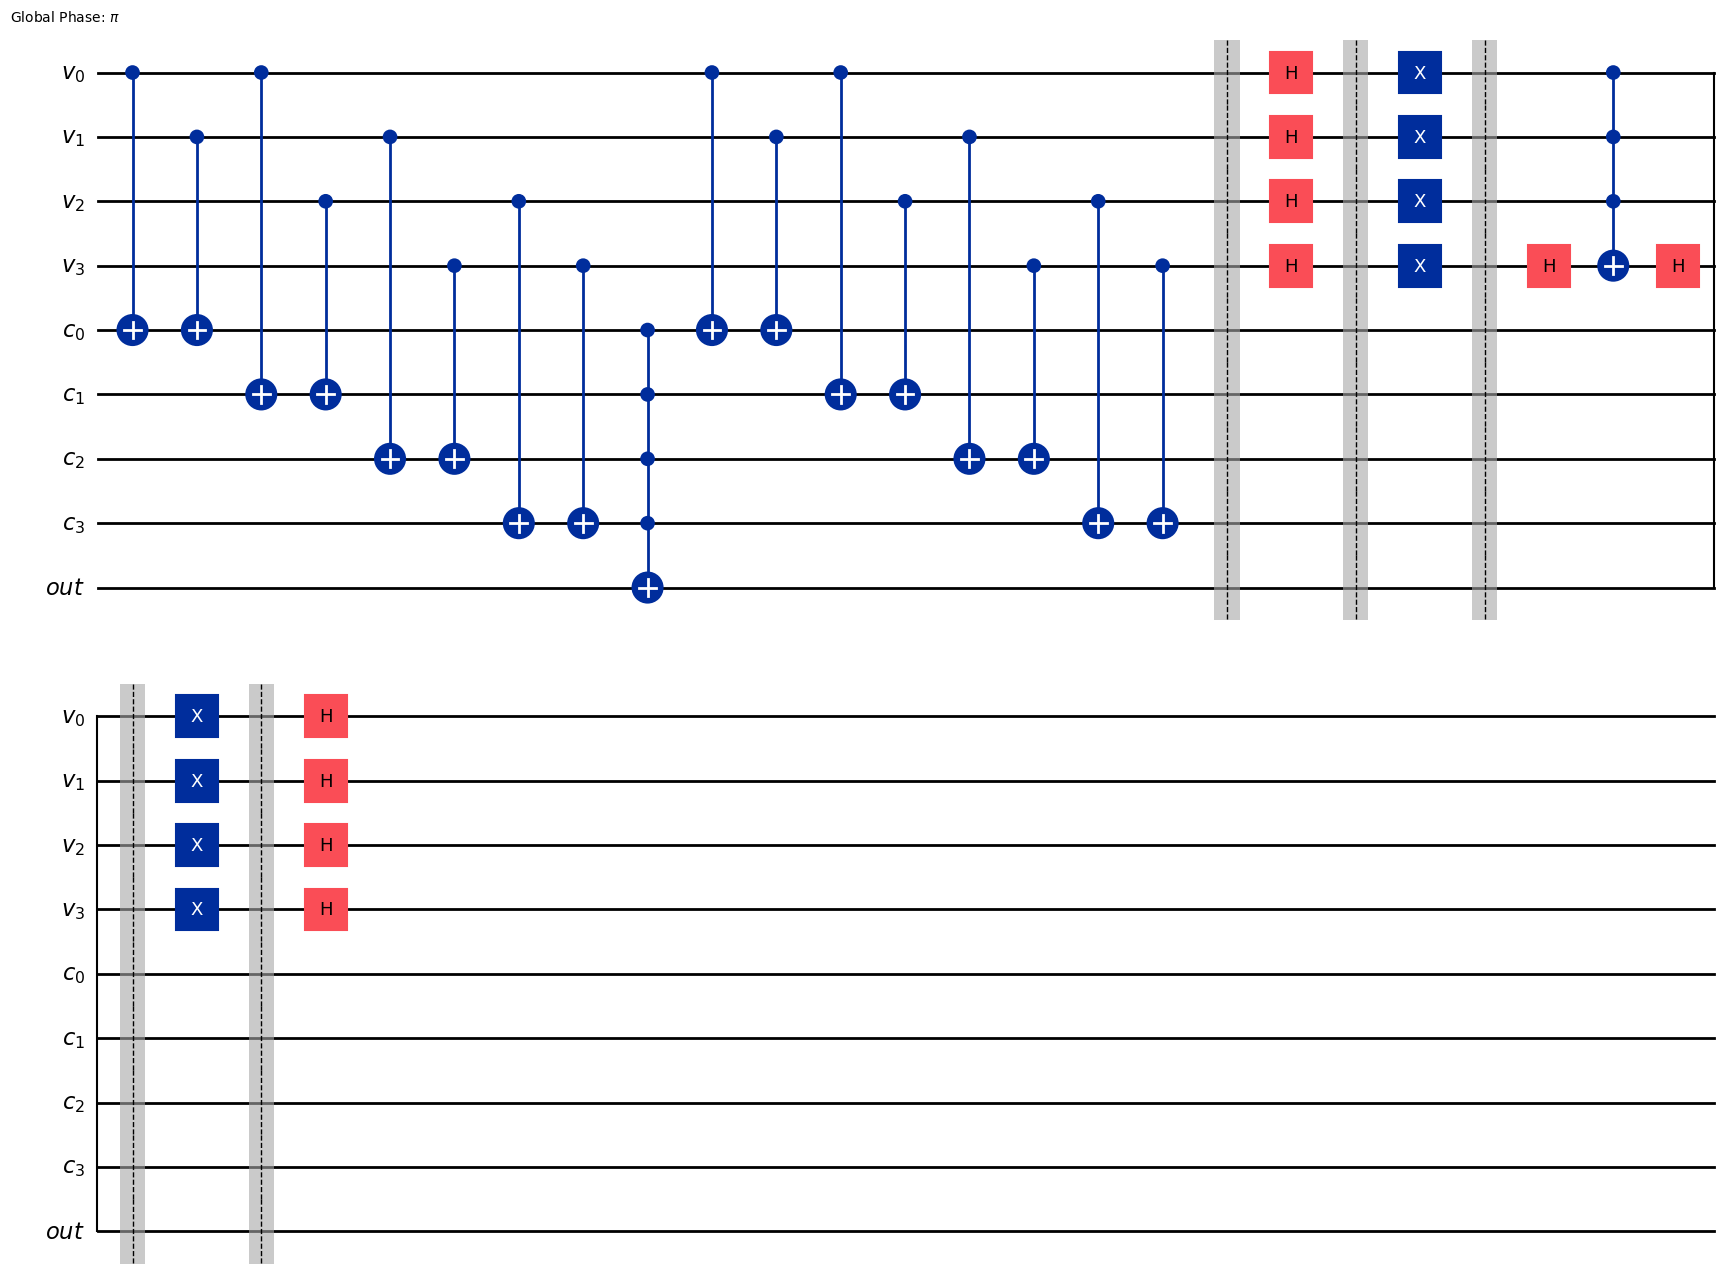

In [6]:
Grover_op = Grover_operator(oracle, insert_barriers=True, name="Grover Op", reflection_qubits=[
                            var_qubits[0], var_qubits[1], var_qubits[2], var_qubits[3]])
Grover_op.draw(output="mpl", style="iqp")

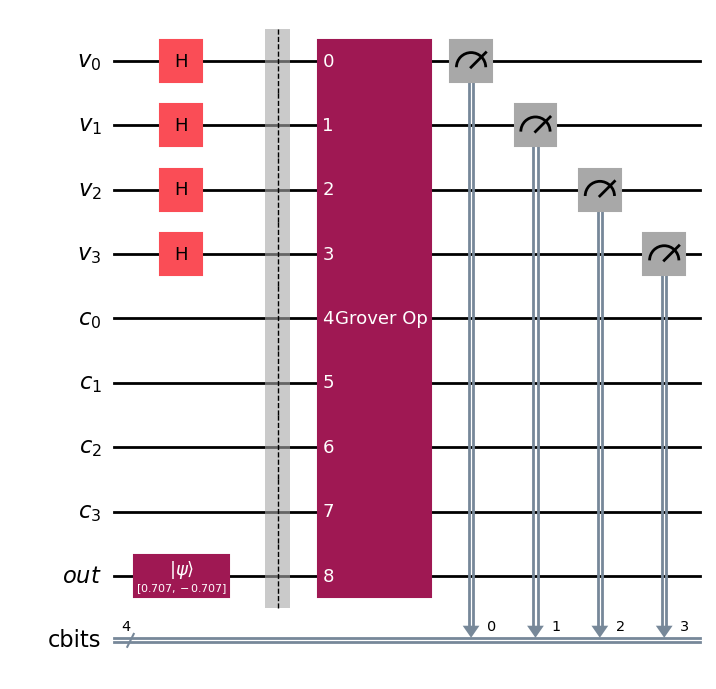

In [7]:
iterations = 1
Grover_circuit = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
Grover_circuit.initialize([1, -1]/np.sqrt(2), output_qubit)

# Enter your code here to create the Grover circuit, using the Grover operator you just created. Remember to apply the Grover operator the correct number of times (iterations) and to measure the variable qubits at the end.

# 1. Apply Hadamard gates to the variable qubits to create a superposition
Grover_circuit.h(var_qubits)
Grover_circuit.barrier()  # for visual separation


# 2. Apply the Grover operator the specified number of iterations

Grover_circuit.compose(Grover_op.power(iterations), inplace=True)

# 3. Measure the variable qubits
Grover_circuit.measure(var_qubits, cbits)


Grover_circuit.draw(output="mpl", style="iqp")

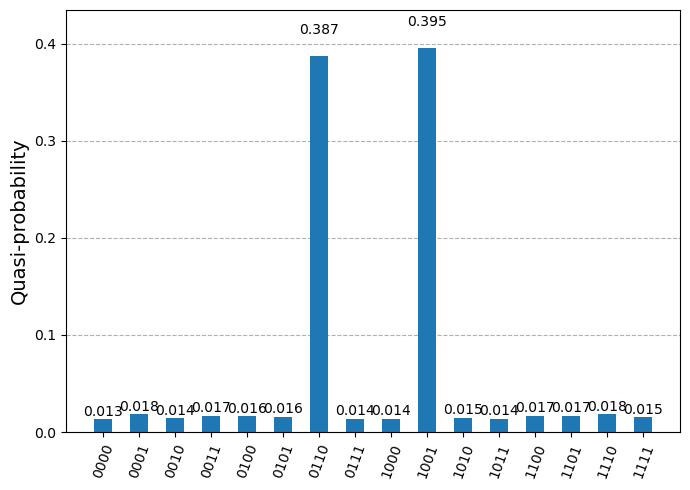

In [10]:
# 4. Simulate the circuit using the statevector simulator to check that the amplitude of the solution state is indeed amplified. You can use the StatevectorSampler primitive for this.

sampler = StatevectorSampler()

# Run using sampler
result = sampler.run([Grover_circuit], shots=5000).result()
# Access result data for PUB 0 and plot distribution
data_pub = result[0].data
counts = data_pub.cbits.get_counts()
plot_distribution(counts)

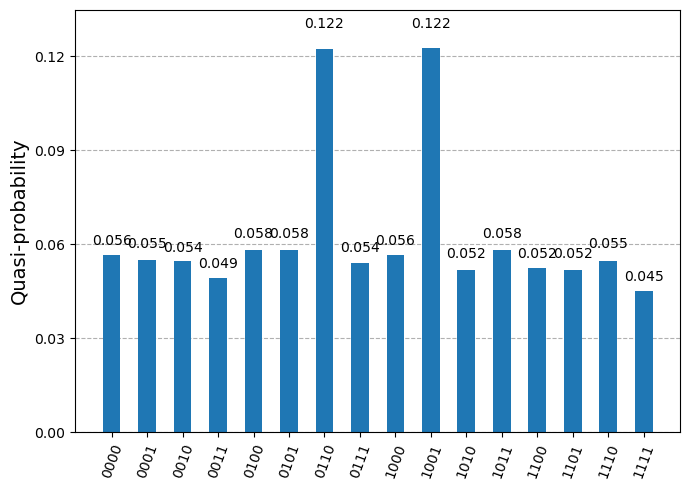

In [11]:
# 5. Run the circuit on the fake backend and plot the results

data = Get_Data_from_Fake_backend(10000, Grover_circuit, FakeAlgiers())

counts = data.cbits.get_counts()
plot_distribution(counts)

There are two bit strings with a much higher probability of measurement than any of the others, `0110` and `1001`. These correspond to the assignments:
```
v0 = 0
v1 = 1
v2 = 1
v3 = 0
```
and
```
v0 = 1
v1 = 0
v2 = 0
v3 = 1
```
which are the two solutions to our sudoku! 


